In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold

In [2]:
df_train=pd.read_csv("train_age_dataset.csv")
df_test=pd.read_csv("test_age_dataset.csv")

In [3]:
df_train=df_train.rename(columns={"Unnamed: 0":"Unnamed"})
df_test=df_test.rename(columns={"Unnamed: 0":"Unnamed"})
df_train=df_train.sort_index(axis=0)
df_test=df_test.sort_index(axis=0)

In [35]:
# import and create the VarianceThreshold object.
from sklearn.feature_selection import VarianceThreshold
vs_constant = VarianceThreshold(threshold=0)

# select the numerical columns only.
numerical_x_train = X_std[numeric]

# fit the object to our data.
vs_constant.fit(numerical_x_train)

# get the constant colum names.
constant_columns = [column for column in numerical_x_train.columns if column not in numerical_x_train.columns[vs_constant.get_support()]]  

# detect constant categorical variables.
constant_cat_columns = [column for column in X[cat] if (len(X[column].unique()) ==1)]
# conctenating the two lists.
all_constant_columns = constant_cat_columns + constant_columns

# drop the constant columns
X_std.drop(labels=all_constant_columns, axis=1, inplace=True)
X_std.drop(labels=all_constant_columns, axis=1, inplace=True)

In [36]:
X_std[all_constant_columns]


""
0
1
2
3
4
...
488872
488873
488874
488875


In [37]:
# make a threshold for quasi constant.
threshold = 0.98

# create empty list
quasi_constant_feature = []
x_train=X_std
# loop over all the columns
for feature in x_train.columns:

    # calculate the ratio.
    predominant = (x_train[feature].value_counts() / np.float(len(x_train))).sort_values(ascending=False).values[0]
    
    # append the column name if it is bigger than the threshold
    if predominant >= threshold:
        quasi_constant_feature.append(feature)   
        
print(quasi_constant_feature)

# drop the quasi constant columns
x_train.drop(labels=quasi_constant_feature, axis=1, inplace=True)
x_test.drop(labels=quasi_constant_feature, axis=1, inplace=True)

['num_of_hashtags_per_action', 'emoji_count_per_action']


NameError: name 'x_test' is not defined

In [216]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488877 entries, 0 to 488876
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed                          488877 non-null  int64  
 1   userId                           488877 non-null  int64  
 2   tier                             488877 non-null  int64  
 3   gender                           488877 non-null  int64  
 4   following_rate                   488877 non-null  float64
 5   followers_avg_age                488877 non-null  float64
 6   following_avg_age                488877 non-null  float64
 7   max_repetitive_punc              488877 non-null  int64  
 8   num_of_hashtags_per_action       488877 non-null  float64
 9   emoji_count_per_action           488877 non-null  float64
 10  punctuations_per_action          488877 non-null  float64
 11  number_of_words_per_action       488877 non-null  float64
 12  av

In [4]:
df_train.describe()

,Unnamed,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,...,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
count,488877.000000,4.888770e+05,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,...,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000,488877.000000
mean,271605.981815,4.236096e+07,1.975382,1.213037,0.082233,0.347520,0.403049,0.739748,0.000277,0.000981,...,0.391013,0.002009,0.074353,0.066927,0.032855,0.141705,0.150401,0.158382,164.765782,1.741643
std,156808.138002,1.821664e+07,0.430707,0.409454,2.467781,0.816334,0.925291,3.075954,0.012221,0.020381,...,0.905303,0.030561,0.211094,0.174791,0.193962,0.402612,0.451999,0.502065,981.988886,1.088559
min,0.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,135779.000000,3.537599e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.040650,0.000000,0.000000,0.002265,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,271560.000000,4.336270e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.124031,0.000000,0.003968,0.015873,0.000000,0.011834,0.014563,0.015873,0.000000,1.000000
75%,407431.000000,5.370523e+07,2.000000,1.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.364486,0.000000,0.060000,0.059016,0.000000,0.117188,0.118644,0.122396,178.666667,2.000000
max,543196.000000,7.904203e+07,3.000000,2.000000,895.304000,4.000000,4.000000,624.000000,2.333333,3.000000,...,75.662281,8.196850,17.201754,18.756140,19.612903,27.905983,45.083333,55.153846,39304.000000,4.000000


In [218]:
df_test.describe()

,Unnamed,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,...,creations,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2
count,54320.000000,5.432000e+04,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,...,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000,54320.000000
mean,271526.164102,4.248125e+07,1.976105,1.211856,0.081204,0.344033,0.397432,0.734794,0.000357,0.000909,...,0.017718,0.393404,0.002133,0.075402,0.067343,0.032848,0.141784,0.152749,0.160141,158.286032
std,156804.297247,1.818136e+07,0.431142,0.408627,3.103205,0.813081,0.917988,2.822803,0.015529,0.017456,...,0.156423,0.929538,0.031136,0.212199,0.179688,0.175984,0.396400,0.481607,0.502513,920.210984
min,5.000000,3.500000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136019.250000,3.547567e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.040816,0.000000,0.000000,0.002243,0.000000,0.000000,0.000000,0.000000,0.000000
50%,271924.000000,4.344565e+07,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.000000,0.003968,0.015789,0.000000,0.011628,0.014493,0.015873,0.000000
75%,407039.750000,5.370713e+07,2.000000,1.000000,0.008621,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009009,0.364427,0.000000,0.060000,0.058333,0.000000,0.117647,0.117647,0.125000,178.714286
max,543183.000000,7.904176e+07,3.000000,2.000000,685.277778,4.000000,4.000000,130.000000,2.333333,1.692308,...,16.915254,34.030303,4.575000,8.897959,8.672727,12.440000,17.060606,24.122449,22.096774,28474.333330


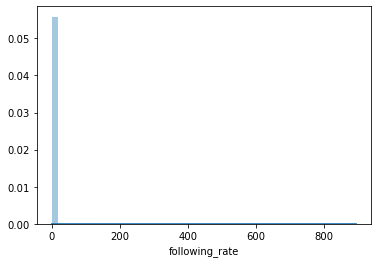

In [5]:
sns.distplot(df_train['following_rate'],kde=True)

In [6]:
percentile_99 = np.percentile(df_train['following_rate'],[99])[0]
percentile_99

0.907407407

In [21]:
df_train[(df_train.following_rate)>percentile_99]

,Unnamed: 0,userId,tier,gender,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,...,content_views,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,age_group
16,16863,32554791,1,1,19.640625,1.921013,1.981818,5,0.0,0.0,...,2.335938,0.007812,0.296875,0.521875,0.015625,0.929688,1.085938,1.171875,119.328358,3
24,26438,34998606,1,1,1.285714,2.065217,2.095890,3,0.0,0.0,...,0.222222,0.031746,0.123016,0.071429,0.031746,0.238095,0.222222,0.111111,185.233333,3
38,507820,51442373,2,2,0.974576,2.230769,2.500000,19,0.0,0.0,...,1.745763,0.000000,0.355932,0.242373,0.008475,0.516949,0.813559,0.584746,170.618644,4
79,514412,58127232,2,1,1.203883,2.090909,2.600000,0,0.0,0.0,...,4.854369,0.000000,1.043689,0.904854,3.524272,0.009709,1.495146,1.582524,197.564103,4
114,394302,50134819,2,1,6.773109,1.984848,1.879195,2,0.0,0.0,...,0.529412,0.016807,0.054622,0.115966,0.000000,0.369748,0.302521,0.016807,126.544444,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488321,497303,55767451,2,1,0.954128,2.000000,2.403226,0,0.0,0.0,...,0.220183,0.000000,0.000000,0.055046,0.000000,0.000000,0.275229,0.000000,684.238095,3
488494,392570,68682495,2,1,1.516129,2.285714,2.409091,2,0.0,0.0,...,0.322581,0.000000,0.177419,0.009677,0.048387,0.016129,0.193548,0.145161,316.433333,4
488568,503673,43706160,2,1,1.861789,1.428571,2.270270,0,0.0,0.0,...,10.365854,0.040650,2.239837,1.939837,5.089431,0.008130,0.447154,8.634146,83.416667,4
488647,53727,38417424,1,1,14.648000,2.121880,2.065491,0,0.0,0.0,...,0.552000,0.008000,0.192000,0.059200,0.024000,0.256000,0.144000,0.256000,123.385045,3


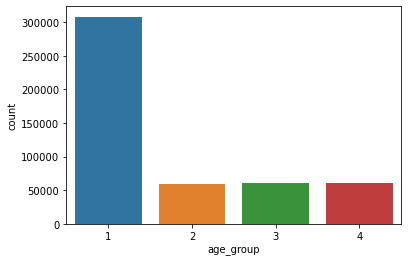

In [11]:
sns.countplot(df_train['age_group'])

In [15]:
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X=df_train.drop(['age_group','userId'],axis=1)
y=df_train['age_group'].astype(int)

In [16]:
features = X.columns
numeric = ['Unnamed', 'following_rate', 'followers_avg_age',
       'following_avg_age', 'max_repetitive_punc',
       'num_of_hashtags_per_action', 'emoji_count_per_action',
       'punctuations_per_action', 'number_of_words_per_action',
       'avgCompletion', 'avgTimeSpent', 'avgDuration', 'avgComments',
       'creations', 'content_views', 'num_of_comments',
       'weekends_trails_watched_per_day', 'weekdays_trails_watched_per_day',
       'slot1_trails_watched_per_day', 'slot2_trails_watched_per_day',
       'slot3_trails_watched_per_day', 'slot4_trails_watched_per_day',
       'avgt2']
cat=['tier','gender']
scaler = StandardScaler()
X_numeric_std = pd.DataFrame(data=scaler.fit_transform(X[numeric]), columns=numeric)
X_std = pd.merge(X_numeric_std, X[cat], left_index=True, right_index=True)

In [ ]:
#,'slot1_trails_watched_per_day','num_of_comments','following_avg_age','followers_avg_age','max_repetitive_punc','num_of_hashtags_per_action','emoji_count_per_action','punctuations_per_action','avgComments'

In [11]:
test=df_test.drop(['userId'],axis=1)
test_numeric_std = pd.DataFrame(data=scaler.fit_transform(test[numeric]), columns=numeric)
test_std = pd.merge(test_numeric_std, test[cat], left_index=True, right_index=True)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state=0,test_size=0.20,stratify=y)

In [12]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

NameError: name 'X_train' is not defined

In [30]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
#class_weights = dict(enumerate(class_weights))
class_weights=dict(dict(zip([1, 2, 3,4], class_weights)))

C:\Users\Khusi\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[1 2 3 4], y=400274    3
7924      2
4704      1
486229    1
267221    2
         ..
179395    4
3809      1
481407    3
340519    4
10269     1
Name: age_group, Length: 391101, dtype: int32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [31]:
params= {'learning_rate':0.1,
         'boosting_type':'gbdt',
         'colsample_bytree':0.7,
        'importance_type':'split', 
        'max_depth':10,
         'min_child_samples':10, 
         'n_estimators':5000,
         'n_jobs':-1,  
         'objective':'multiclass',
         'random_state':1, 
         'reg_alpha':1.6, 
         'reg_lambda':1.1,
         'subsample':0.7,
         'min_data_in_leaf': 55,
         'num_classes':4}

In [ ]:
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train,y_train,eval_set=(X_test,y_test),eval_metric='multi_error',early_stopping_rounds=100,categorical_feature=cat)

In [49]:
X_std.head()


,Unnamed,following_rate,followers_avg_age,following_avg_age,max_repetitive_punc,num_of_hashtags_per_action,emoji_count_per_action,punctuations_per_action,number_of_words_per_action,avgCompletion,...,num_of_comments,weekends_trails_watched_per_day,weekdays_trails_watched_per_day,slot1_trails_watched_per_day,slot2_trails_watched_per_day,slot3_trails_watched_per_day,slot4_trails_watched_per_day,avgt2,tier,gender
0,-0.041152,-0.033323,-0.425708,-0.435592,-0.240494,-0.022681,-0.048151,-0.080256,-0.276638,0.622942,...,-0.065725,-0.154841,-0.239871,-0.169388,-0.351965,0.054423,-0.249069,-0.167788,2,1
1,0.852157,-0.033323,-0.425708,-0.435592,-0.240494,-0.022681,-0.048151,0.401860,-0.039070,0.449679,...,-0.065725,-0.292007,-0.276234,-0.169388,-0.141475,-0.332747,-0.247944,-0.083775,2,2
2,-1.363062,-0.033323,-0.425708,-0.435592,-0.240494,-0.022681,-0.048151,-0.080256,-0.276638,0.000385,...,-0.065725,-0.352226,-0.379712,-0.169388,-0.345046,-0.332747,-0.315462,-0.167788,2,1
3,0.006454,-0.033323,-0.425708,-0.435592,-0.240494,-0.022681,-0.048151,-0.080256,-0.276638,-1.718402,...,-0.065725,-0.352226,-0.373284,-0.169388,-0.351965,-0.332747,-0.298724,-0.167788,2,1
4,-0.130625,-0.033323,-0.425708,-0.435592,-0.240494,-0.022681,-0.048151,-0.080256,-0.276638,0.588242,...,-0.065725,-0.352226,-0.101532,-0.169388,-0.331606,-0.205806,0.043711,-0.167788,2,2


In [80]:
%%time
err = [] 
y_pred_tot_lgm = np.zeros((len(test), 4))


fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X_std,y):
    X_train,X_test  = X_std.iloc[train_index], X_std.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m = CatBoostClassifier(n_estimators=10000,
                       random_state=2020,
                       eval_metric='Accuracy',
                       learning_rate=0.08,
                       depth=8,
                       bagging_temperature=0.3,
                       task_type='GPU'
                       #num_leaves=64
                       
                       )
    m.fit(X_train, y_train,eval_set=[(X_test,y_test)], early_stopping_rounds=100,verbose=200)
    pred_y = m.predict(X_test)
    print(i, " err_lgm: ", accuracy_score(y_test,pred_y))
    err.append(accuracy_score(y_test,pred_y))
    y_pred_tot_lgm+= m.predict_proba(test)
    i = i + 1
y_pred_tot_lgm=y_pred_tot_lgm/10
sum(err)/10

0:	learn: 0.6935696	test: 0.6913353	best: 0.6913353 (0)	total: 42.4ms	remaining: 7m 4s
200:	learn: 0.7481823	test: 0.7412658	best: 0.7413680 (197)	total: 5.83s	remaining: 4m 44s
400:	learn: 0.7609554	test: 0.7464818	best: 0.7465840 (399)	total: 11.4s	remaining: 4m 33s
600:	learn: 0.7697215	test: 0.7488750	best: 0.7491409 (572)	total: 17.1s	remaining: 4m 27s
800:	learn: 0.7777785	test: 0.7507773	best: 0.7507773 (768)	total: 22.9s	remaining: 4m 22s
bestTest = 0.7516568483
bestIteration = 889
Shrink model to first 890 iterations.
1  err_lgm:  0.7516568483063328
0:	learn: 0.6931173	test: 0.6921944	best: 0.6921944 (0)	total: 32.4ms	remaining: 5m 23s
200:	learn: 0.7487664	test: 0.7414703	best: 0.7417158 (199)	total: 5.93s	remaining: 4m 48s
400:	learn: 0.7617395	test: 0.7470749	best: 0.7470954 (399)	total: 11.8s	remaining: 4m 41s
600:	learn: 0.7713056	test: 0.7491000	best: 0.7491000 (596)	total: 17.6s	remaining: 4m 36s
800:	learn: 0.7794968	test: 0.7501432	best: 0.7504909 (783)	total: 23.8s	r

0.752420336893991

In [33]:
accuracy_score(y_test, lgb_clf.predict(X_test))

0.7501329569628539

In [34]:
f1_score(y_test, lgb_clf.predict(X_test),average='weighted')

0.7488735003380923

In [227]:
f1_score(y_test, cb_clf.predict(X_test),average='weighted')

0.7482038501058044

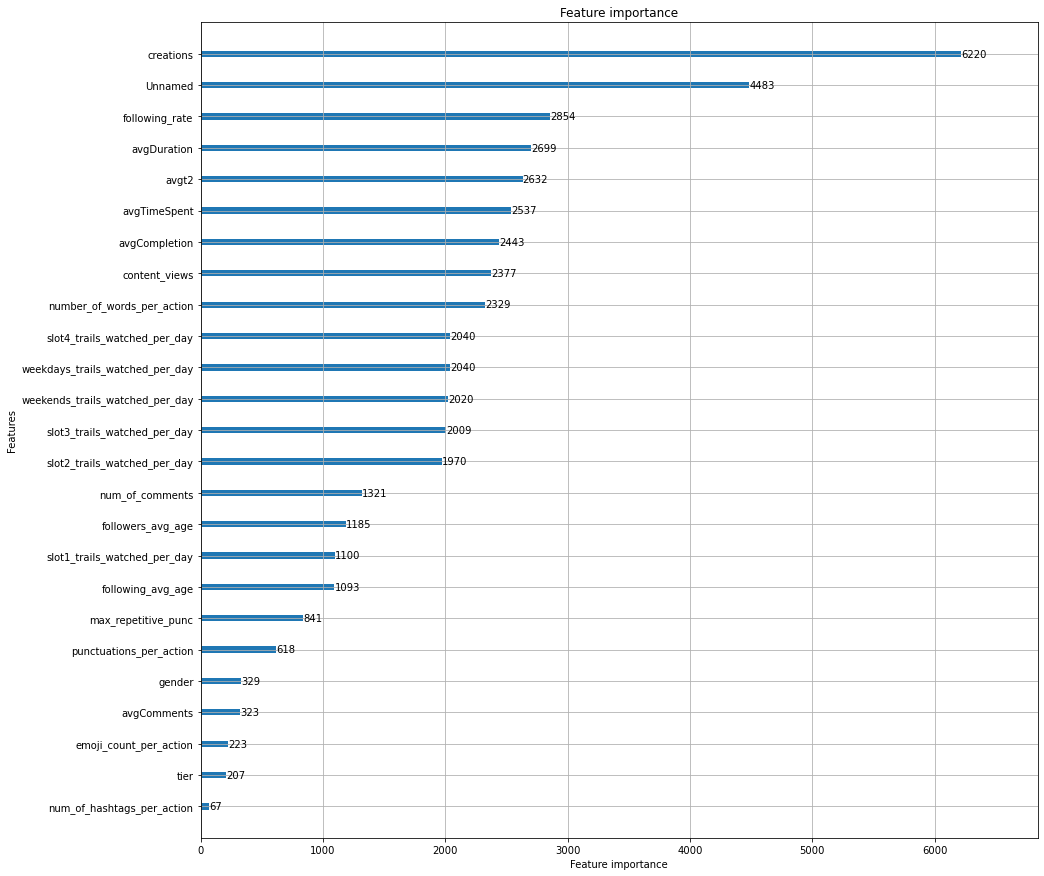

In [15]:
ax = lgb.plot_importance(lgb_clf, max_num_features=40, figsize=(15,15))
plt.show()

In [16]:
preds=lgb_clf.predict(test_new)

In [228]:
preds=cb_clf.predict(test)

In [17]:
#submission = pd.DataFrame({'prediction':preds})
submission = pd.DataFrame(data=preds,columns=['prediction'])
submission.to_csv(r"E:\ML\Cascade Cup\submit.csv",index=False)

In [73]:
map_ = {0:1,1:2,2:3,3:4}

In [79]:
sub=pd.DataFrame()
sub['prediction'] = [np.argmax(x) for x in y_pred_tot_lgm]
sub['prediction']=sub['prediction'].map(map_)
sub.to_csv(r"E:\ML\Cascade Cup\submit2.csv",index=False)